# Testing Data Aumentation for Base DNN Model

Investigating possible data aumentation using daily rebalancing instead of monthly ones. Described in chapter 4.10.

Input: 6 key indicators passed separately

Output: optimal max-shape portfolio with normal restrictions for the next period

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

from cvxpy.error import SolverError

In [3]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense
from keras.regularizers import L2
import os
os.chdir(os.path.expanduser('../'))

from helper_functions import train_and_evaluate_model, run_full_backtesting

## Data Pre-processing

In [4]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [5]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [6]:
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Instead of calculating input data and target on the day of rebalancing, we calculate for all available bussiness day increasing training dataset by 20 times.

In [7]:
all_bussiness_days = df_countries[days_to_recalculate[0]:days_to_recalculate[-1]].index
all_bussiness_days

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-18',
               ...
               '2023-11-21', '2023-11-22', '2023-11-24', '2023-11-27',
               '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
               '2023-12-04', '2023-12-05'],
              dtype='datetime64[ns]', length=6019, freq=None)

Preparing features

In [8]:
x = []
for date in all_bussiness_days:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

    if len(x) % 100 == 0:
        print('.', end='')

x = np.array(x)
x.shape

............................................................

(6019, 6, 162)

Preparing targets

In [9]:
y = []
for day in all_bussiness_days:
    data_period = df_countries.loc[day:].iloc[:22]
    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_normal_constraints(
            acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except SolverError:
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / \
            summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
    
    y.append(optimal_portfolio.values)

    if len(y) % 100 == 0:
        print('.', end='')

y = np.array(y)
y.shape

............................................................

(6019, 27)

## Train/validation/test split

In [10]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = all_bussiness_days[:val_split]
print('Dates for train', dates_for_training)
x_train = x[:val_split]
print('x train shape', x_train.shape)
y_train = y[:val_split]
print('y train shape', y_train.shape)

Dates for train DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-18',
               ...
               '2016-09-19', '2016-09-20', '2016-09-21', '2016-09-22',
               '2016-09-23', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', length=4213, freq=None)
x train shape (4213, 6, 162)
y train shape (4213, 27)


In [11]:
# Validation
dates_for_validation = all_bussiness_days[val_split:test_split]
print('Dates for validation', dates_for_validation)
x_val = x[val_split:test_split]
print('x val shape', x_val.shape)
y_val = y[val_split:test_split]
print('y val shape', y_val.shape)

Dates for validation DatetimeIndex(['2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06',
               '2016-10-07', '2016-10-10', '2016-10-11', '2016-10-12',
               '2016-10-13', '2016-10-14',
               ...
               '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14',
               '2019-02-15', '2019-02-19', '2019-02-20', '2019-02-21',
               '2019-02-22', '2019-02-25'],
              dtype='datetime64[ns]', length=602, freq=None)
x val shape (602, 6, 162)
y val shape (602, 27)


In [17]:
# Test
dates_for_test = all_bussiness_days[test_split:]

print('Dates for test', dates_for_test)
x_test = x[test_split:]
print('x test shape', x_test.shape)
y_test = y[test_split:]
print('y test shape', y_test.shape)

Dates for test DatetimeIndex(['2019-02-26', '2019-02-27', '2019-02-28', '2019-03-01',
               '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2023-11-21', '2023-11-22', '2023-11-24', '2023-11-27',
               '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01',
               '2023-12-04', '2023-12-05'],
              dtype='datetime64[ns]', length=1204, freq=None)
x test shape (1204, 6, 162)
y test shape (1204, 27)


## Model definition and training

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │        31,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,027 (125.11 KB)

 Trainable params: 32,027 (125.11 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5013 - val_loss: 0.0036
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0015 - val_loss: 0.0017
Train error: 0.001406221417710185
Val error: 0.0017440248047932982
Test error: 0.0018816750962287188
Execution time 2.04 s

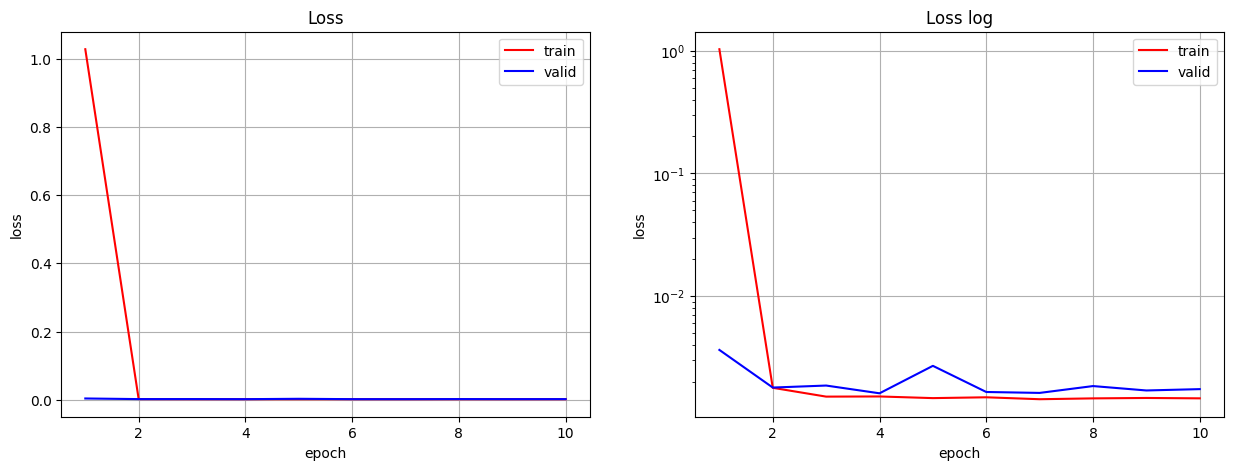

In [83]:
dnn_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Flatten(),
    Dense(32, activation='relu',
          kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(dnn_model, x_train, y_train,
                         x_val, y_val, x_test, y_test,
                         epochs=10)

## Backtesting

In [84]:
dates_for_test = days_to_recalculate[-58:]

day_idx = []
i = 0
for day in all_bussiness_days:
    if day in dates_for_test:
        day_idx.append(i)
    i += 1

x_test_monthly = x[day_idx] # for testing pass only monthly data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


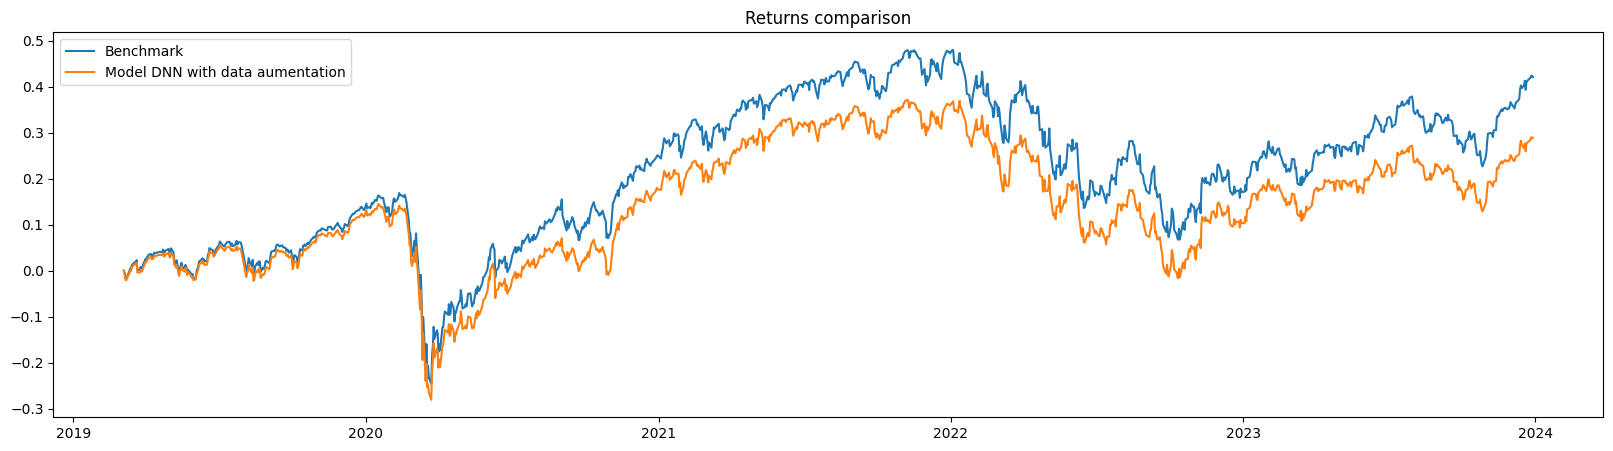

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model DNN with data aumentation,0.05467,0.201534,0.271269,0.312872,-0.371863,538.0,0.147016,-0.711335


In [85]:
models = {
    'Model DNN with data aumentation': (dnn_model, x_test_monthly),
}

df_results = run_full_backtesting(data_provider, models)
df_results